**Supplementary code and notes**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
import pickle
import math
from operator import add
import torch
import torch.nn as nn
import pyphi
np.set_printoptions(threshold=sys.maxsize)


Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Marchman R, Tononi G.
  (2018). PyPhi: A toolbox for integrated information theory.
  PLOS Computational Biology 14(7): e1006343.
  https://doi.org/10.1371/journal.pcbi.1006343

Documentation is available online (or with the built-in `help()` function):
  https://pyphi.readthedocs.io

To report issues, please use the issue tracker on the GitHub repository:
  https://github.com/wmayner/pyphi

For general discussion, you are welcome to join the pyphi-users group:
  https://groups.google.com/forum/#!forum/pyphi-users

To suppress this message, either:
  - Set `WELCOME_OFF: true` in your `pyphi_config.yml` file, or
  - Set the environment variable PYPHI_WELCOME_OFF to any value in your shell:
        export PYPHI_WELCOME_OFF='yes'



In [2]:
# NOTE: 'timestep' variable used to denote the timestep in which the perturbation will occur, and 'n' is the number of...
#... iterations performed by the ECA. 

def apply_rule(rule_function, n, perturbation_boolean, timestep, cell):
    ini_state = initial_state(2*n + 1)
    rv = []
    rv.append(ini_state)
    if perturbation_boolean == True:
        for i in range(1, n):
            if i == timestep:
                timestep_update = rule_function(ini_state)
                if timestep_update[cell] == 0:
                    timestep_update[cell] = 1
                else:
                    timestep_update[cell] = 0
                    
                rv.append(timestep_update)
                ini_state = timestep_update
                
            else:
                timestep_update = rule_function(ini_state)
                rv.append(timestep_update)
                ini_state = timestep_update
          
    else:
        for i in range(1, n):
            timestep_update = rule_function(ini_state)
            rv.append(timestep_update)
            ini_state = timestep_update
        
    return np.array(rv)

In [3]:
def plot_for_average(prob_dist, x_axis, title_string, x_string, y_string):

    plt.style.use('ggplot')
    x = x_axis
    x_pos = [i for i, _ in enumerate(x)]
    y = prob_dist

    fig = plt.figure(figsize=(12,4))
    plt.bar(x_pos, y, color='green')
    plt.xlabel(x_string)
    plt.ylabel(y_string)
    plt.title(title_string)

    plt.xticks(x_pos, x)

    return plt.show()

In [4]:
def initial_state(width):
    initial = np.zeros((1, width), dtype=int)
    if width % 2 == 0:
        initial = np.insert(initial, int(width / 2), values=0, axis=1)
        initial[0, int(width / 2)] = 1
        return initial[0]
    else:
        initial[0, int(width / 2)] = 1
        return initial[0]

In [5]:
def make_rule(integer):
    binary = str(bin(integer)[2:])
    
    if len(binary) < 8:
        binary = binary.zfill(8)
    
    def rule_function(array):
        row1 = array
        next_row = array.copy()
        for x in range(1, len(row1)-1):
                
            # Given cell state is "off", then update given the neighbors like - 
            if row1[x] == 0:
                if (row1[x-1] == 0) and (row1[x+1] == 0):
                    next_row[x] = int(binary[7])

                if (row1[x-1] == 0) and (row1[x+1] == 1):
                    next_row[x] = int(binary[6])

                if (row1[x-1] == 1) and (row1[x+1] == 0):
                    next_row[x] = int(binary[3])

                if (row1[x-1] == 1) and (row1[x+1] == 1):
                    next_row[x] = int(binary[2])

            # Given cell state is "on", then update given the neighbors like -   
            else:
                if (row1[x-1] == 0) and (row1[x+1] == 0):
                    next_row[x] = int(binary[5])

                if (row1[x-1] == 0) and (row1[x+1] == 1):
                    next_row[x] = int(binary[4])

                if (row1[x-1] == 1) and (row1[x+1] == 0):
                    next_row[x] = int(binary[1])

                if (row1[x-1] == 1) and (row1[x+1] == 1):
                    next_row[x] = int(binary[0])

        return np.array(next_row)

    return rule_function

In [6]:
rule_30 = make_rule(30)

# Transition Probability Matrix

In [7]:
def TPM(rule_function, number_of_cells):
    
    maximum_range = 2**(number_of_cells+2)
    TPM_matrix = []
    
    for i in range(maximum_range):
        
        binary = bin(i)[2:]
        binary = binary.zfill(number_of_cells+2)
        
        state_iter_array = [int(i) for i in str(binary)]
        next_timestep = rule_function(state_iter_array)
        
        
        TPM_matrix.append(next_timestep)    
        
    return TPM_matrix

Below is the transition probability matrix for three cells with open boundary conditions. Since we are using open boundary conditions, **not toroidal or periodic boundary conditions**, we need to expand the state size to an array of size 5 cells. We do this because the transition probability matrix records all the transition probabilities, and in order for the transition to abide by the rules of elementary cellular automata, there needs to be cells to the left and right of the cell in question. So for example, to record all the transitions that are possible for the three cell mechanism, we must first realize that each unique 3-cell state has 4 possible subconfigurations, i.e one for each of the possible combinations that the first and last cell in a state array can take. 

In [8]:
TPM_matrix = TPM(rule_30, 3)

# Cause Repertoire

We will label the middle three cells in the 5-cell array (again, need to analyze the cause-effect repertoire of the open boundary condition ECA) *A*, *B*, and *C*. The first cell shall be labeled $\gamma$ and the last cell shall be labeled $\delta$. 

The cause repetoire of a Mechanism $M_t$ in its current state $m_t$ can be obtained from the TPM using
Bayes’ rule. For example, suppose we want to consider the cause-repertoire $p_{cause}(\gamma AB_{t-1}|A_{t} = 1)$, we can use Bayes' rule, given below...

$p_{cause}(\gamma AB_{t-1}|A_{t} = 1)$ = $\frac{p_{cause}(A_{t} = 1|\gamma AB_{t-1}) \cdot p_{uc}(\gamma AB_{t-1})}{p(A_t = 1)}$

In [9]:
#NOTE: character_string_value refers to the following conversion that must be done, 'a' maps to 1, 'b' maps to 2, 'c' maps to 3, etc.

def cause_repertoire_single_order(TPM_matrix, character_string_value, value_binary):

    x_axis_label_array = []
    cause_repertoire_distribution = []
    numerator = 0
    denominator = 0
    
    for i in range(len(TPM_matrix)):
        x = 0
        denominator += 1
        binary = bin(i)[2:]
        binary = binary.zfill(len(TPM_matrix[0]))
        
        if TPM_matrix[i][character_string_value] == value_binary:
            
            numerator += 1
            
            for item in x_axis_label_array:
                if item == binary[character_string_value-1:character_string_value+2]:
                    x = "stop"
                    break
            
            if x == "stop":
                continue
            else:
                cause = 1 * (1/8)
                cause_repertoire_distribution.append(cause)
                x_axis_label_array.append(binary[character_string_value-1:character_string_value+2])
                
        else:
            
            for item in x_axis_label_array:
                if item == binary[character_string_value-1:character_string_value+2]:
                    x = "stop"
                    break
            
            if x == "stop":
                continue
                
            else:

                cause = 0 * (1/8)
                cause_repertoire_distribution.append(cause)
                x_axis_label_array.append(binary[character_string_value-1:character_string_value+2])
    
    cause_repertoire_distribution = np.array(cause_repertoire_distribution) / (numerator/denominator)
            
    return cause_repertoire_distribution, x_axis_label_array
    
    
    

In [10]:
cause_repertoire_distribution, x_axis_labels = cause_repertoire_single_order(TPM_matrix, 1, 1)

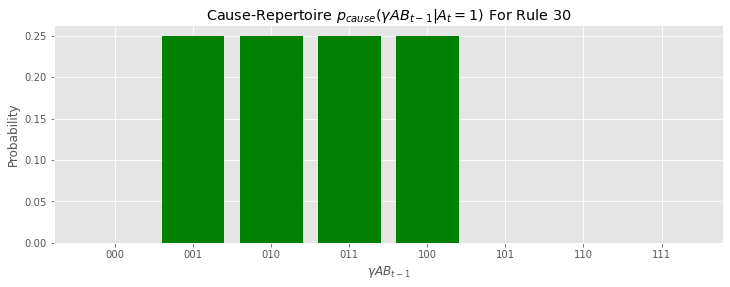

In [11]:
plot_for_average(cause_repertoire_distribution, x_axis_labels, "Cause-Repertoire $p_{cause}(\gamma AB_{t-1}|A_{t} = 1)$ For Rule 30", "$\gamma AB_{t-1}$", "Probability")

# Effect Repertoire

Consider the effect repertoire $p_{ef}(\gamma AB_{t+1}|A_{t} = 1)$. This is just equal to the expansion below...

$p_{ef}(\gamma AB_{t+1}|A_{t} = 1)$ = $p_{ef}(\gamma_{t+1}| A_{t} = 1) \cdot p_{ef}(A_{t+1}| A_{t} = 1) \cdot p_{ef}(B_{t+1}| A_{t} = 1)$

In [12]:
def effect_repertoire_single_order(TPM_matrix, character_string_value, value_binary):
    
    effect_repertoire_distribution = []
    x_axis_label_array = []
    hold_array = []
    
    denominator = 0
    
    for i in range(len(TPM_matrix)):
        
        binary = bin(i)[2:]
        binary = binary.zfill(len(TPM_matrix[0]))
        
        if binary[character_string_value] == str(value_binary):
            
            denominator += 1
            sub_array = list(TPM_matrix[i][character_string_value-1:character_string_value+2])
            
            hold_array.append(sub_array)
            
    for i in range(8):
        numerator = 0
        
        binary = bin(i)[2:]
        binary = binary.zfill(3)
        
        x_axis_label_array.append(binary)
        check = [int(i) for i in str(binary)]
        
        for item in hold_array:
            if item == check:
                numerator += 1
        
        effect_repertoire_distribution.append(numerator/denominator)
    
    return effect_repertoire_distribution, x_axis_label_array

In [13]:
effect_repertoire_distribution, x_axis_labels = effect_repertoire_single_order(TPM_matrix, 1, 1)

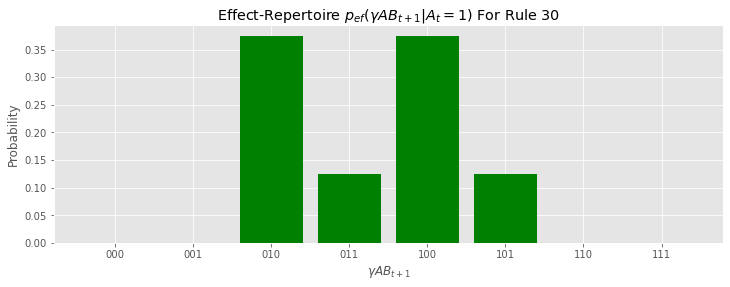

In [14]:
plot_for_average(effect_repertoire_distribution, x_axis_labels, "Effect-Repertoire $p_{ef}(\gamma AB_{t+1}|A_{t} = 1)$ For Rule 30", "$\gamma AB_{t+1}$", "Probability")

In [15]:
print(sum(effect_repertoire_distribution))

1.0


This concludes gathering the IIT related *information* measures, now we have to *integrate* the information by taking second order irreducible mechanisms. Once we have these post-first order mechanisms, we can start investigating the emergence of *concepts* and see how it relates to emergent structures in ECA. 

In [16]:
cause_repertoire_distribution = [0.125 for i in range(8)]

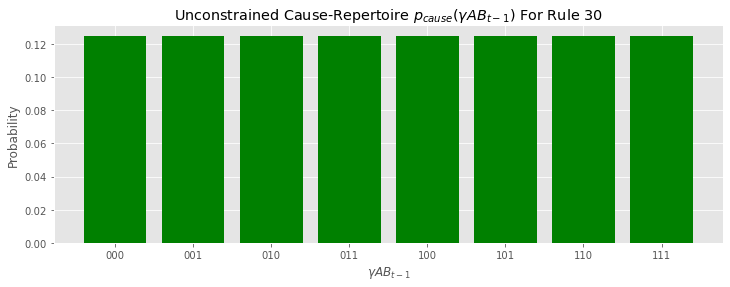

In [17]:
plot_for_average(cause_repertoire_distribution, x_axis_labels, "Unconstrained Cause-Repertoire $p_{cause}(\gamma AB_{t-1})$ For Rule 30", "$\gamma AB_{t-1}$", "Probability")

# Higher-Order Irreducible Cause-Effect Repertoires

## Higher-Order Cause-Repertoire

In [18]:
def cause_repertoire_higher_order(TPM_matrix, start_character_string_value, end_character_string_value, binary_values_string):
    
    cause_repertoire_distribution_list = []
    x_axis_labels_list = []
    
    for i in range(start_character_string_value, end_character_string_value+1):
        
        value = int(binary_values_string[i-start_character_string_value])
        cause_repertoire_distribution, x_axis_labels = cause_repertoire_single_order(TPM_matrix, i, value)
        
        ####################################################################################33
        
        if i == start_character_string_value:
            for i in range(len(x_axis_labels)):
                x_axis_labels[i] = x_axis_labels[i] + '0'
                
        else:
            for i in range(len(x_axis_labels)):
                x_axis_labels[i] = '0' + x_axis_labels[i] 
        
        ####################################################################################
        
        cause_repertoire_distribution_list.append(cause_repertoire_distribution)
        x_axis_labels_list.append(x_axis_labels)
        
    array_fixed = np.zeros(2**4)
    x_axis = []
    
    for i in range(2**4):
        binary = bin(i)[2:]
        binary = binary.zfill(4)
        x_axis.append(binary)
        

    for i in range(len(x_axis_labels_list)):
        for j in range(len(x_axis_labels_list[0])):
            binary = x_axis_labels_list[i][j]
            integer = int(binary, 2)
            
            if array_fixed[integer] == 0:
                array_fixed[integer] = 1
            
            array_fixed[integer] = array_fixed[integer] * cause_repertoire_distribution_list[i][j]
            
            
    total = sum(array_fixed)
    
    
    array_fixed = array_fixed/total
    
    return array_fixed, x_axis

In [19]:
cause_repertoire_distribution, x_axis_labels = cause_repertoire_higher_order(TPM_matrix, 1, 2, '11')

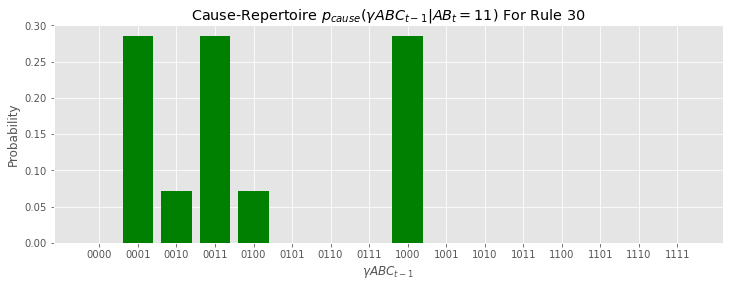

In [20]:
plot_for_average(cause_repertoire_distribution, x_axis_labels, "Cause-Repertoire $p_{cause}(\gamma ABC_{t-1}|AB_{t} = 11)$ For Rule 30", "$\gamma ABC_{t-1}$", "Probability")

In [21]:
print(sum(cause_repertoire_distribution))

0.9999999999999999


## Higher-Order Effect-Repertoire

In [22]:
def effect_repertoire_higher_order(TPM_matrix, start_character_string_value, end_character_string_value, binary_values_string):
    
    effect_repertoire_distribution = []
    x_axis_label_array = []
    hold_array = []
    
    denominator = 0
    
    for i in range(len(TPM_matrix)):
        
        binary = bin(i)[2:]
        binary = binary.zfill(len(TPM_matrix[0]))
        
        if binary[start_character_string_value:end_character_string_value+1] == binary_values_string:
            
            denominator += 1
            
            sub_array = list(TPM_matrix[i][start_character_string_value-1:end_character_string_value+2])
            
            hold_array.append(sub_array)
            
    for i in range(16):
        numerator = 0
        
        binary = bin(i)[2:]
        binary = binary.zfill(4)
        
        x_axis_label_array.append(binary)
        check = [int(i) for i in str(binary)]
        
        for item in hold_array:
            if item == check:
                numerator += 1
        
        effect_repertoire_distribution.append(numerator/denominator)
    
    return effect_repertoire_distribution, x_axis_label_array

In [23]:
effect_repertoire_distribution, x_axis_labels = effect_repertoire_higher_order(TPM_matrix, 1, 2, '11')

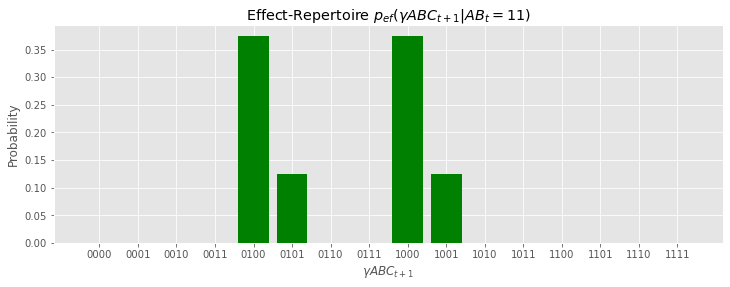

In [24]:
plot_for_average(effect_repertoire_distribution, x_axis_labels, "Effect-Repertoire $p_{ef}(\gamma ABC_{t+1}|AB_{t} = 11)$", "$\gamma ABC_{t+1}$", "Probability")

In [25]:
print(sum(effect_repertoire_distribution))

1.0


# Using PyPhi to Calculate IIT Measures

## Existence: Mechanisms in a state having causal power.

In [26]:
TPM_matrix = TPM(rule_30, 3)

In [27]:
cm = np.array([
    [0, 0, 0, 0, 0],
    [1, 1, 1, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 1, 1, 1],
    [0, 0, 0, 0, 0]
])

In [28]:
labels = ('$\gamma$', 'A', 'B', 'C', '$\delta$')

## Information requires selectivity. Start by setting up the subsystem. 

In [29]:
network = pyphi.Network(TPM_matrix, cm=cm, node_labels=labels)

In [30]:
state = (1, 1, 1, 1, 0)
subsystem = pyphi.Subsystem(network, state, [1, 2, 3])

In [31]:
pyphi.compute.phi(subsystem)

0.0625

In [32]:
A, B, C = subsystem.node_indices

## Information: “Differences that make a difference to a system from its own intrinsic perspective.”

In [33]:
subsystem.cause_repertoire((B,), (A, B, C))

array([[[[[0.  ],
          [0.25]],

         [[0.25],
          [0.  ]]],


        [[[0.25],
          [0.  ]],

         [[0.25],
          [0.  ]]]]])

In [34]:
subsystem.effect_repertoire((B,), (A, B, C))

array([[[[[0. ],
          [0. ]],

         [[0. ],
          [0. ]]],


        [[[0.5],
          [0. ]],

         [[0.5],
          [0. ]]]]])

In [35]:
subsystem.cause_info((A,), (A, B, C))

0.166668

In [36]:
subsystem.effect_info((A,), (A, B, C))

0.0

In [37]:
subsystem.cause_effect_info((A,), (A, B, C))

0.0

## A mechanism generates information only if it has both selective causes and selective effects within the system.

In [38]:
np.array_equal(subsystem.effect_repertoire((B,), (A, B, C)), subsystem.unconstrained_effect_repertoire((A, B, C)))

False

Since the effect repertoire is not the same as the unconstrained effect repertoire, this mechanism has both selective causes and selective effects within the system!

## Integrated information: The information generated by the whole that is irreducible to the information generated by its parts.

A mechanism generates integrated information only if it has both integrated causes and integrated effects.

## The maximally integrated cause repertoire over the power set of purviews is the “core cause” specified by a mechanism.

In [39]:
mic = subsystem.mic((B, C))
mic.phi

0.25

Similarly, the mie() method returns the “core effect” or maximally-irreducible effect (MIE).

## A mechanism that specifies a maximally irreducible cause-effect repertoire.

In [40]:
concept_A = subsystem.concept((B,))
concept_A.phi

0.25

## Information: A conceptual structure C (constellation of concepts) is the set of all concepts generated by a set of elements in a state.

In [41]:
network = pyphi.Network(TPM_matrix, cm=cm, node_labels=labels)
state = (1, 1, 1, 1, 0)
subsystem = pyphi.Subsystem(network, state, [1, 2, 3])
A, B, C = subsystem.node_indices

In [42]:
ces = pyphi.compute.ces(subsystem)

In [43]:
ces.labeled_mechanisms

(['B'], ['C'], ['B', 'C'])

In [44]:
ces.phis

[0.25, 0.25, 0.25]

In [45]:
subsystem.null_concept.phi

0.0

## Assessing the conceptual information CI of a conceptual structure (constellation of concepts).

In [64]:
print(len([0,1,1,1,1,1,1,1,1,1,1,1,1,1,0]))

15


In [85]:
rule_30 = make_rule(30)
TPM_matrix = TPM(rule_30, 14)
for i in range(len(TPM_matrix)):
    if list(TPM_matrix[i][1:15]) == [1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1]:

        print(i)
        print(bin(i)[2:].zfill(16))

15273
0011101110101001
15282
0011101110110010
15283
0011101110110011
15300
0011101111000100
